In [1]:
!nvidia-smi

Wed Apr 16 15:29:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# module, library import

# dataloader
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# model configuration
import logging
from transformers import GPT2Config

# model
# import torch
# import torch.nn as nn

import os
import numpy as np
from tqdm import tqdm
from transformers import GPT2Tokenizer,GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast

import csv
# import kss

In [ ]:
# dataloader
class WellnessAutoRegressiveDataset(Dataset):
  """Wellness Auto Regressive Dataset"""
  def __init__(self,
               file_path,
               n_ctx = 128
               ):
    self.file_path = file_path
    self.data =[]
    self.tokenizer = PreTrainedTokenizerFast.from_pretrained("taeminlee/kogpt2")

    bos_token_id = [self.tokenizer.bos_token_id]
    eos_token_id = [self.tokenizer.eos_token_id]
    pad_token_id = [self.tokenizer.pad_token_id]

    file = open(self.file_path, 'r', encoding='utf-8')

    while True:
      line = file.readline()
      if not line:
        break
      datas = line.split("    ")
      index_of_words = bos_token_id +self.tokenizer.encode(datas[0]) + eos_token_id + bos_token_id + self.tokenizer.encode(datas[1][:-1])+ eos_token_id
      pad_token_len = n_ctx - len(index_of_words)

      index_of_words += pad_token_id * pad_token_len

      self.data.append(index_of_words)

    file.close()

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    item = self.data[index]
    return item

# model configuration
logger = logging.getLogger(__name__)

# KoGPT2 Config
kogpt2_config = {
    "activation_function": "gelu_new",
    "attn_pdrop": 0.1,
    "bos_token_id": 50256,
    "embd_pdrop": 0.1,
    "eos_token_id": 50256,
    "initializer_range": 0.02,
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_layer": 12,
    "n_positions": 1024,
    "output_past": True,
    "resid_pdrop": 0.1,
    "summary_activation": None,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": True,
    "summary_type": "cls_index",
    "summary_use_proj": True,
    "vocab_size": 50000
}
def get_kogpt2_config():
    return GPT2Config.from_dict(kogpt2_config)


# model
class DialogKoGPT2(nn.Module):
  def __init__(self):
        super(DialogKoGPT2, self).__init__()
        self.kogpt2 = GPT2LMHeadModel.from_pretrained("taeminlee/kogpt2")

  def generate(self,
               input_ids,
               attention_mask=None,
               do_sample=True,
               max_length=60,
               top_p=0.92,
               top_k=50,
               temperature= 0.6,
               no_repeat_ngram_size=None,
               num_return_sequences=1,
               early_stopping=False,
               ):
    # pad_token_id setting (In the case of "Taeminlee/kogpt2", number 3 is "pad_token")
    pad_token_id = self.kogpt2.config.pad_token_id or 3

    if attention_mask is None:
        attention_mask = (input_ids != pad_token_id).long()

    return self.kogpt2.generate(input_ids=input_ids,
                                attention_mask=attention_mask,
                                do_sample=do_sample,
                                max_length=max_length,
                                top_p=top_p,
                                top_k=top_k,
                                temperature=temperature,
                                no_repeat_ngram_size= no_repeat_ngram_size,
                                num_return_sequences=num_return_sequences,
                                early_stopping = early_stopping,
              )

  def forward(self, input_ids, attention_mask=None, labels=None):
    if labels is not None:
        outputs = self.kogpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    else:
        outputs = self.kogpt2(input_ids=input_ids, attention_mask=attention_mask)
    return outputs

  def __getitem__(self,index):
    item = self.data[index]
    attention_mask = [1 if token != self.tokenizer.pad_token_id else 0 for token in item]
    return {
        'input_ids': torch.tensor(item),
        'attention_mask': torch.tensor(attention_mask)
    }


In [6]:
torch.cuda.is_available()

True

In [ ]:
# Training
root_path = '/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM'
train_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_train.txt"
val_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_validation.txt"
save_ckpt_path = f"{root_path}/checkpoint/kogpt2-wellness-auto-regressive_small.pth"

# cpu or gpu(cuda) setting
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

batch_size = 16

# Training data loader
train_dataset = WellnessAutoRegressiveDataset(train_data_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data loader
val_dataset = WellnessAutoRegressiveDataset(val_data_path)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#
n_epoch = 6
save_step = len(train_loader) // 3
learning_rate = 5e-5


# Model initialization
model = DialogKoGPT2()
model.to(device)

# Loss function and optimizer
loss_fct = torch.nn.CrossEntropyLoss(ignore_index=3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
val_losses = []

train_log_path = f"{root_path}/training_log_250417.csv"
valid_log_path = f"{root_path}/valid_log_250417.csv"
best_val_loss = float('inf')

with open(train_log_path, 'a', newline='') as train_file, open(valid_log_path, 'a', newline='') as valid_file:
    train_writer = csv.writer(train_file)
    valid_writer = csv.writer(valid_file)

    for epoch in range(n_epoch):
        model.train()
        epoch_losses = []

        with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
            for i, data in enumerate(train_loader):
                optimizer.zero_grad()
                data = torch.stack(data).transpose(1, 0).to(ctx)

                outputs = model(data, labels=data)
                _, logits = outputs[:2]

                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = data[..., 1:].contiguous()

                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                epoch_losses.append(loss.item())

                # Save checkpoint
                if (i % save_step == 0) or (i == len(train_loader) - 1):
                    torch.save({
                        'epoch': epoch,
                        'train_step': i,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss
                    }, f"{root_path}/checkpoint/kogpt2_epoch{epoch}_step{i}.pth")
                
                train_writer.writerow([epoch, i, loss.item(), np.mean(epoch_losses)])
                pbar.update(1)
                pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(epoch_losses):.3f})")

        # Validation
        model.eval()
        val_epoch_losses = []

        with torch.no_grad(), tqdm(total=len(val_loader), desc="Validation") as val_pbar:
            for j, val_data in enumerate(val_loader):
                val_data = torch.stack(val_data).transpose(1, 0).to(ctx)

                val_outputs = model(val_data, labels=val_data)
                _, val_logits = val_outputs[:2]

                val_shift_logits = val_logits[..., :-1, :].contiguous()
                val_shift_labels = val_data[..., 1:].contiguous()

                val_loss = loss_fct(val_shift_logits.view(-1, val_shift_logits.size(-1)), val_shift_labels.view(-1))
                val_losses.append(val_loss.item())
                val_epoch_losses.append(val_loss.item())

                valid_writer.writerow([epoch, j, val_loss.item(), np.mean(val_epoch_losses)])
                val_pbar.update(1)
                val_pbar.set_postfix_str(f"Val Loss: {val_loss.item():.3f} ({np.mean(val_epoch_losses):.3f})")

        # Check the best val loss 
        avg_val_loss = np.mean(val_epoch_losses)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss
            }, f"{root_path}/checkpoint/kogpt2_best_val.pth")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Validation: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s, Val Loss: 2.086 (1.148)]


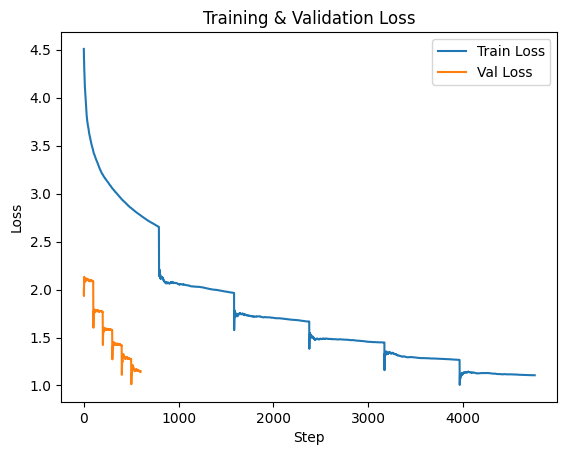

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

train_log = pd.read_csv(f"{root_path}/training_log_250417.csv", header=None, names=['epoch', 'step', 'loss', 'avg_loss'])
val_log = pd.read_csv(f"{root_path}/valid_log_250417.csv", header=None, names=['epoch', 'step', 'val_loss', 'avg_val_loss'])

plt.plot(train_log['avg_loss'], label='Train Loss')
plt.plot(val_log['avg_val_loss'], label='Val Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [13]:
display(train_log)
display(val_log)

,epoch,step,loss,avg_loss
0,0,0,4.506742,4.506742
1,0,1,4.319559,4.413151
2,0,2,4.338248,4.388183
3,0,3,4.343478,4.377007
4,0,4,3.999922,4.301590
...,...,...,...,...
4753,5,788,1.238072,1.106726
4754,5,789,1.041947,1.106644
4755,5,790,1.291764,1.106878
4756,5,791,1.025002,1.106774


,epoch,step,val_loss,avg_val_loss
0,0,0,1.998965,1.998965
1,0,1,1.865469,1.932217
2,0,2,2.247794,2.037409
3,0,3,2.374771,2.121750
4,0,4,2.174411,2.132282
...,...,...,...,...
595,5,95,0.994933,1.142601
596,5,96,0.905789,1.140159
597,5,97,1.135787,1.140115
598,5,98,1.029928,1.139002


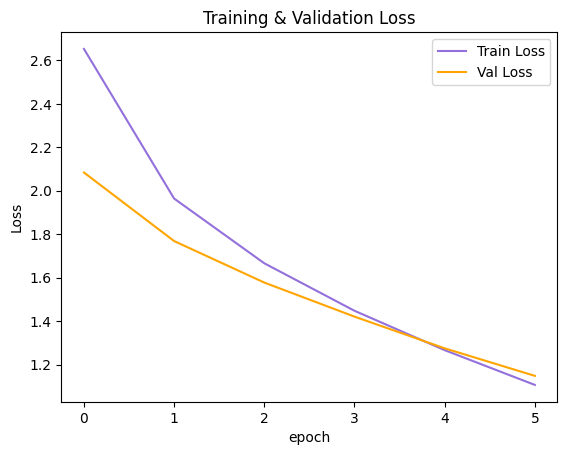

In [35]:
train_loss_df=train_log.drop_duplicates(subset='epoch', keep='last')
val_loss_df=val_log.drop_duplicates(subset='epoch', keep='last')


plt.plot(range(6),train_loss_df['avg_loss'], label='Train Loss',color='mediumpurple')
plt.plot(range(6),val_loss_df['avg_val_loss'], label='Val Loss',color='orange')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

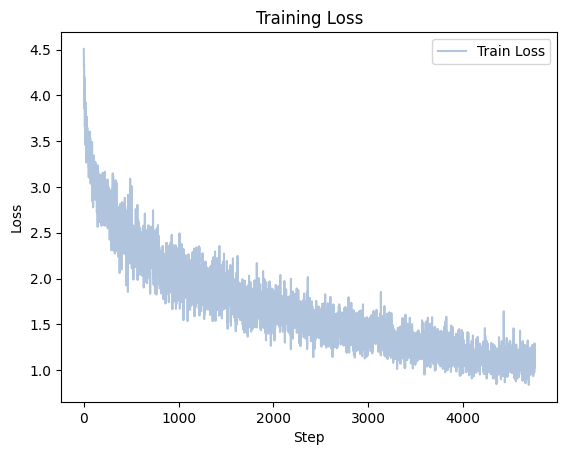

In [30]:
plt.plot(train_log['loss'], label='Train Loss',color='lightsteelblue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

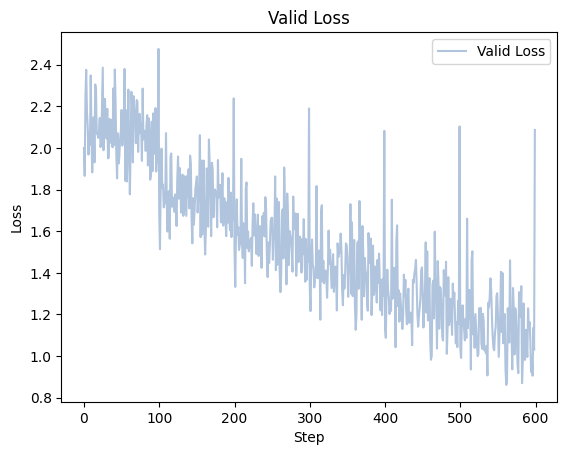

In [31]:
plt.plot(val_log['val_loss'], label='Valid Loss',color='lightsteelblue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Valid Loss')
plt.show()